# Score-Based Classification

A particular focus of this course is the use of machine learning models for automated decision-making. Now that we've been introduced to the fundamental idea of finding patterns in data, let's jump straight into a problem of *predictive modeling*. Predictive modeling is based on a simple idea: let's use past observations to make decisions about the future, in an automated way. 
  
### To Lend Or Not To Lend?

Banks are in the business of lending money, and they must often decide when to loan whom how much money and under what terms. When deciding whether to loan a sum of money, there are two major competing questions: 

1. How much profit does the bank stand to make if the loan is paid off in full? 
2. What is the risk that an individual might *default* on their loan and fail to pay it back? In this case, the bank may lose a significant fraction of the loan amount. 

Banks can try to balance these risks by controlling interest rates. Higher interest rates increase prospective profit if the loan is repaid in full, but also increase the risk that an individual may be unable to keep up with payments. 

The judgment of whether to extend an individual a loan is handled by human experts. Recently, human experts have been seeking assistance from machine learning algorithms. As in most predictive modeling, the idea is to use the past to predict the future. Here, we'll consider simple modeling problem in which we aim to learn patterns in when individuals are able to pay off loans, and use these patterns to make predictions. 

We'll first load in the `pandas` package and use the `read_csv` command to acquire our data for this problem as a `pd.DataFrame`. [This data set was produced by Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset); it is a *simulated* data set based on patterns in real world data, which, of course, is sensitive and confidential. For today, we are only going to focus on the first 1,000 rows of data. 


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
#| echo: false
pd.options.mode.chained_assignment = None  

In [3]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/credit_risk_dataset.csv"

In [4]:
df = pd.read_csv(url)

Let's take a look at an excerpt of the data. 

In [6]:
df = df.head(1000).copy() #grab first 1000 rows
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,46610,RENT,6.0,DEBTCONSOLIDATION,B,18000,10.71,1,0.39,N,3
996,24,48000,RENT,5.0,PERSONAL,A,18000,6.54,1,0.38,N,2
997,23,24000,OWN,0.0,PERSONAL,A,8000,5.79,0,0.33,N,3
998,25,55000,RENT,2.0,EDUCATION,C,18000,12.84,1,0.33,N,2


Each row of this data set describes a single loan and the attributes of the borrower. For visualization purposes, today we are going to focus on just three of the columns: 

- `loan_percent_income` is the ratio of the loan amount to the annual income of the individual. 
- `loan_int_rate` is the interest rate on the loan. 
- `loan_status` describes whether or not the individual defaulted on the loan. This column has value `1` if the individual defaulted on the loan and value `0` if the loan was repaid in full. 

Our primary predictive interest is whether or not a borrower is likely to default on a loan. How common is this in our data set?

In [8]:
df['loan_status'].mean()
#percentage of defaults

0.553

In this data, roughly 55% of borrowers default on their loan. An important aspect of this learning is the *base rate for prediction.* If we predicted that every borrower would default on a loan, we would be right 55% of the time. So, if we want to find patterns in our data set and use those patterns to make predictions, we should aim for accuracy greater than 55%. 


So, can we find some patterns? Here is a labeled scatterplot of our simplified data set. 

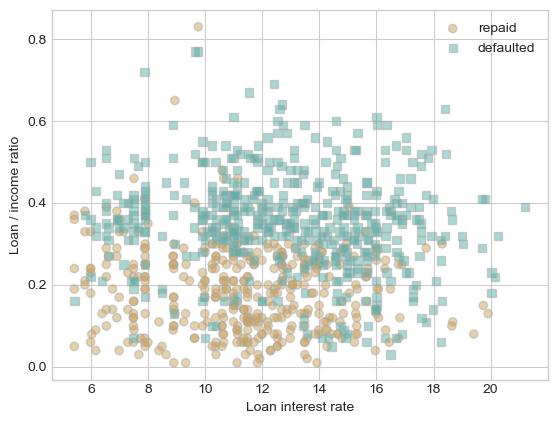

In [9]:
def scatter_data(ax, df):

    markers = ["o" , ","]
    for i in range(2):
        to_plot = df[df["loan_status"] == i]
        ax.scatter(to_plot["loan_int_rate"], to_plot["loan_percent_income"], c = to_plot["loan_status"], vmin = -0.5, vmax = 1.5, facecolors='none', edgecolors = "darkgrey", alpha = 0.5, label = f"{['repaid', 'defaulted'][i]}", cmap = "BrBG", marker = markers[i])
        ax.legend()
        ax.set(xlabel = "Loan interest rate", ylabel = "Loan / income ratio")

df = df.head(1000)
fig, ax = plt.subplots(1, 1)
scatter_data(ax, df)

Although it looks difficult to completely separate the defaulted loans from the loans which were repaid in full, it does look like there is some pattern to find. Loans which were repaid in full concentrate in the lower right corner of the visualization. This makes sense -- these are loans which have low interest rates and which are relatively small sums relative to the annual resources of the borrower. 

A very common approach in problems like this one is to assign, to each loan applicant $i$, a *score* $s_i$ which predicts their likelihood to default on a loan. Higher scores indicate greater reliability. Let's formulate a linear score function: 

$$
\begin{aligned}
    s_i = w_1 \times (\text{loan interest rate}_i) + w_2 \times (\text{loan percent income/loan/income ratio}_i)\;.
\end{aligned}
$$


We can write this score function much more compactly by defining a data point 

$$
\begin{aligned}
    \mathbf{x}_{i} = \left(\text{loan interest rate}_i, \text{loan percent income}_i\right)
\end{aligned}
$$ 

and weight vector 

$$
\begin{aligned}
    \mathbf{w} = \left(w_1, w_2\right)\;.
\end{aligned}
$$

Then, we can compactly write our score function as 

$$
\begin{aligned}
    s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle\;. 
\end{aligned} 
$$ {#eq-risk-score}

Let's implement this score in Python.  

In [10]:
def linear_score(w, x0, x1):
    return w[0] * x0 + w[1] * x1
#scoer of all data simiultaneously

Now we can plot this score function in the data space. 

In [11]:
#| code-fold: true


def plot_score(ax, score_fun, w, df):
    """
    Plot a given score function on axis ax with weights w and data df. 
    """

    x0_col = "loan_int_rate"
    x1_col = "loan_percent_income"

    x0_min, x0_max = df[x0_col].min(), df[x0_col].max()
    x1_min, x1_max = df[x1_col].min(), df[x1_col].max()

    x0 = np.linspace(x0_min, x0_max, 101)
    x1 = np.linspace(x1_min, x1_max, 101)

    X0, X1 = np.meshgrid(x0, x1)
    S = score_fun(w, X0, X1)

    ticks = np.linspace(0, 101, 6)

    im = ax.contourf(X0, X1, S, origin = "lower", extent = (x0_min, x0_max, x1_min, x1_max),  cmap = "BrBG", vmin = 2*S.min() - S.max(), vmax = 2*S.max() - S.min())
    
    ax.set(xlabel = "Loan interest rate", ylabel = "Loan / income ratio")
    
    cbar = plt.colorbar(im, )
    cbar.set_label("Predicted score")

def score_viz(score_fun, w, df):
    fig, ax = plt.subplots(1, 2, figsize = (7, 2.7)) 
    plot_score(ax[0], score_fun, w, df)
    plot_score(ax[1], score_fun, w, df)
    scatter_data(ax[1], df)
    plt.tight_layout()

To see the scores, we need to make an initial choice about the weight vector $\mathbf{w}$. 

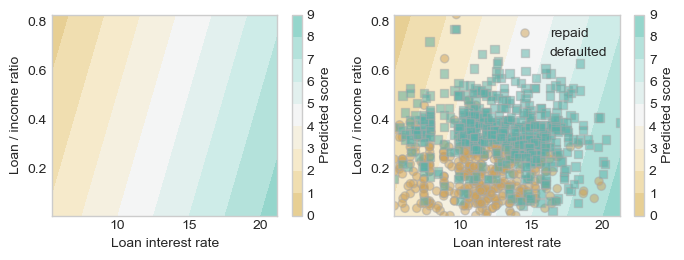

In [12]:
w = np.array([0.4, -2.0])
score_viz(linear_score, w, df)

Hmmm, that doesn't look so good. Ideally, we'd like the higher scores to line up with the borrowers who defaulted, and the lower scores to line up with the borrowers who fully repaid their loans. Can we find a better choice? 

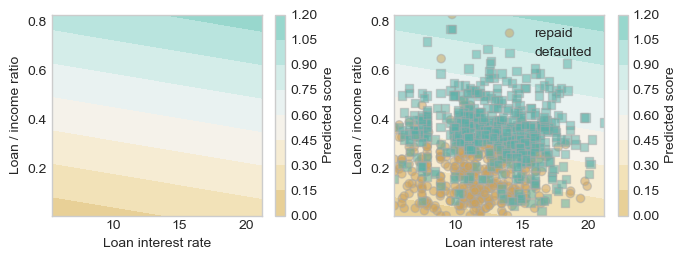

In [13]:
w = np.array([0.01, 1.1])
score_viz(linear_score, w, df)

This looks a bit better! [You might be wondering: isn't there a better way to choose the weight vector $\mathbf{w}$ than to guess and check? Of course there is! This is the topic of *model training*, which we will come to soon.]{.aside}

### From Scores to Predictions

Ok, great -- we have a risk score for historical applicants. We can even compute risk scores for *future* applicants: plug their data into @eq-risk-score. But in order to make a decision, we need to conver the score into a yes-no decision. A common way to do this is called *thresholding*: we pick a threshold $t$ and approve a loan to individual $i$ of $s_i < t$. Loan granted if $s_i < t$.

In [14]:
#| code-fold: true

def plot_threshold(ax, score_fun, w, df, threshold):
    """
    Plot the t-level-set of a given score function on axis ax with weights w and data df. 
    """
    x0_col = "loan_int_rate"
    x1_col = "loan_percent_income"

    x0_min, x0_max = df[x0_col].min(), df[x0_col].max()
    x1_min, x1_max = df[x1_col].min(), df[x1_col].max()

    x0 = np.linspace(x0_min, x0_max, 101)
    x1 = np.linspace(x1_min, x1_max, 101)

    X0, X1 = np.meshgrid(x0, x1)
    S = score_fun(w, X0, X1)

    ax.contour(X0, X1, S, levels = [threshold], colors = ["black"], linestyles = ["--"])

Now we can pick a threshold and see how it does in dividing borrowers who fully repay loans from borrowers who default: 

In [15]:
threshold = 0.4 # = t

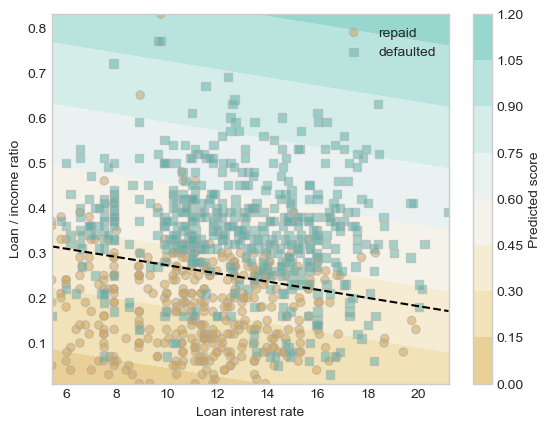

In [16]:
#| label: fig-linear-score
#| fig-cap: Linear score-based classification.
fig, ax = plt.subplots(1, 1)
plot_score(ax, linear_score, w, df)
scatter_data(ax, df) 
plot_threshold(ax, linear_score, w,  df, threshold)

Something interesting to notice here is that our two step method of computing a linear score function and thresholding gave us the same *linear* classification pattern as the one we saw in @fig-examples-with-patterns-2. 

Finally, once we've picked the weight vector $\mathbf{w}$ and a threshold function $t$, we are ready to simulate making decisions. For example, with our current weights and threshold, we can add a column with what our retrospective "decisions" would have been on this historical data. Here is a function that generates the column. 

In [22]:
def predict(score_fun, w, threshold, df):
    
    #make binary predictions for data df using a supplied score function with weights w and supplied threshold. 
    
    scores = score_fun(w, df['loan_int_rate'], df['loan_percent_income'])
    return 1 * (scores > threshold)

Now let's use this function to add the predictions as a new column in the data frame: 

In [23]:
df["decision"] = predict(linear_score, w, threshold, df) 
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,decision
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,46610,RENT,6.0,DEBTCONSOLIDATION,B,18000,10.71,1,0.39,N,3,1
996,24,48000,RENT,5.0,PERSONAL,A,18000,6.54,1,0.38,N,2,1
997,23,24000,OWN,0.0,PERSONAL,A,8000,5.79,0,0.33,N,3,1
998,25,55000,RENT,2.0,EDUCATION,C,18000,12.84,1,0.33,N,2,1


Would our decisions have accurately reflected who in fact defaulted? One way to address this question is by measuring the *accuracy* of our decisions, which we can compute using vectorized code:  

In [24]:
(df["decision"] == df["loan_status"]).mean()

0.767

This accuracy is much higher than the base rate, suggesting that we have indeed learned some amount of pattern in our data. 

## What About Nonlinear Scores?

You'll notice in @fig-linear-score that the decision boundary is a straight line. This is due to the way that we chose to compute scores. Recall that the  score function we used is $s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$. Since we imposed a threshold $t$, the decision boundary is defined by the equation $t = s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$. Generically, this is the equation of a hyperplane (technically, an affine subspace). The dimension of this space is $p-1$, where $p$ is the number of features. Here we have two features, so the decision boundary is a $2-1=1$-dimensional subspace--i.e. a line. 

What if we think a curved decision boundary would be more appropriate? In that case, we need to define a score function that factors in the features in a nonlinear way. 

We started by representing each point as a 2-vector of predictors $\mathbf{x} = \left(\text{loan interest rate}, \text{loan percent income}\right)$. Let's now add a *feature map* $\phi$ that accepts this vector and adds three *nonlinear* functions of the predictors: 

$$
\begin{aligned}
    \phi(\mathbf{x}) = 
        \left(\begin{matrix}
            \text{loan interest rate} \\ 
            \text{loan percent income} \\
            \left(\text{loan interest rate}\right)^2 \\  
            \left(\text{loan percent income}\right)^2 \\ 
            \text{loan interest rate} \times \text{loan percent income}
        \end{matrix}\right)
\end{aligned}
$$

Because the new features are order-2 polynomials in the predictors, this feature map is often called the *quadratic feature map*. 

We'll still use an inner product to compute our score but now the formula will be [In order for this formula to make sense, we now need $\mathbf{w}\in \mathbb{R}^5$.]{.aside}
$$
\begin{aligned}
    s_i = \langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle\;.
\end{aligned}
$$

Here's an implementation of a score function with quadratic features: 

In [25]:
def quadratic_score(w, X0, X1):
    return w[0]*X0 + w[1]*X1 + w[2]*X0**2 + w[3]*X1**2 + w[4]*X0*X1

Now we can set a new vector of weights $\mathbf{w}\in \mathbb{R}^5$ and a threshold $t$. 

In [26]:
w = np.array([0.01, 1, 0.0005, 0.6, 0.001])
threshold = 0.5

Our classification now looks like this: 

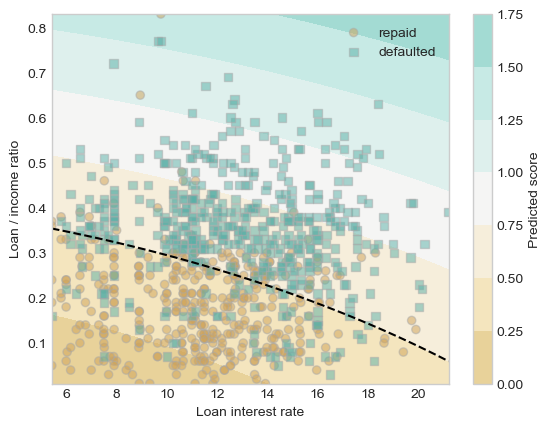

In [27]:
#| label: fig-quadratic-score
#| fig-cap: quadratic score-based classification.

fig, ax = plt.subplots(1, 1)
plot_score(ax, quadratic_score, w, df)
scatter_data(ax, df)
plot_threshold(ax, quadratic_score, w,  df, threshold)

How accurate were we? 

In [28]:
df["decision"] = predict(quadratic_score, w, threshold, df)
(df["decision"] == df["loan_status"]).mean()

0.777

Our nonlinear score function was very slightly more accurate than our linear score function on training data. A few things to keep in mind: 

- Performance on training data is not always a reliable indicator of performance on unseen data. 
- Adding nonlinear features is one way of adding flexibility to a model, allowing that model to learn complicated, "wiggly" decision patterns. As we saw with [the Palmer penguins case study](../chapters/02-black-box-classification.qmd), too much model flexibility can lead to worse predictive performance. We'll regularly revisit the problem of balancing flexibility/features against predictive generalization throughout these notes. 


### Recap

So, we looked at a simplified data set in which we were able to observe some *features* of each prospective borrower $i$ in the form of a vector $\mathbf{x}_i$. We then computed a *score* for each borrower $s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$ and used a threshold to decide whether or not to make a loan: the loan is approved if $s_i \leq t$ for a chosen threshold $t$. We can think of this as a decision-making model for the loan approval problem. 

Is that the end of the story? Of course not! There are many questions remaining. 

- **Model Evaluation**: How do we actually measure whether our decision-making model is good or not? Is accuracy the right measure? Is computing accuracy on the training data reliable? How would the model perform on unseen data that wasn't used to decide $\mathbf{w}$ or $t$? What other ways could we measure the performance of models?
- **Legitimacy**: Is it morally and politically appropriate to use algorithmic decision-making in the context of loan applications? What is the potential for disparate harm? What is the potential for contributing to the reinforcement of historically disparity? In what cases could algorithmic loan-making be appropriate in a democratic society? In what cases could it constitute a violation of personal political or moral rights? 
- **Task Choice**: How was the data collected? Is it complete? Why did I choose a certain set of predictors and targets? Are my predictors and targets reliable measurements of what they claim to represent? Whose interests are served by the existence of a machine learning model that completes this task?
- **Algorithm Design**: What algorithm was used to find the model (i.e. the separating line)? Is that algorithm guaranteed to converge? Will it converge quickly? Would a different algorithm find a better model? Or would it find a model that is equally good more quickly?
- **Vectorization**: Instead of classifying points in a measurement space, how could I instead classify images, videos, or bodies of text? 

We'll discuss all of these questions -- in approximately this order -- later in these notes. 